In [1]:
import os
import sys
import gym
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf

from PPO.ppo import PPO
from A2C.a2c import A2C
from A3C.a3c import A3C
from DDQN.ddqn import DDQN
from DDPG.ddpg import DDPG

from keras.backend.tensorflow_backend import set_session
from keras.utils import to_categorical

from utils.atari_environment import AtariEnvironment
from utils.continuous_environments import Environment
from utils.networks import get_session

Using TensorFlow backend.


In [2]:
gym.logger.set_level(40)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
class attrdict(dict):
    def __init__(self, *args, **kwargs):
        dict.__init__(self, *args, **kwargs)
        self.__dict__ = self

In [4]:
args = attrdict(gpu=True, env='CartPole-v1', type='PPO', is_atari=False, 
                consecutive_frames=4, render=True, n_threads=16, nb_episodes=10_000,
               training_interval=30, batch_size=4096, gather_stats=True, buffer_size=2048, epochs=10)

In [5]:
set_session(get_session())
summary_writer = tf.summary.FileWriter(args.type + "/tensorboard_" + args.env)

In [6]:
# Environment Initialization
if(args.is_atari):
    # Atari Environment Wrapper
    env = AtariEnvironment(args)
    state_dim = env.get_state_size()
    action_dim = env.get_action_size()
elif(args.type=="DDPG"):
    # Continuous Environments Wrapper
    env = Environment(gym.make(args.env), args.consecutive_frames)
    env.reset()
    state_dim = env.get_state_size()
    action_space = gym.make(args.env).action_space
    action_dim = action_space.high.shape[0]
    act_range = action_space.high
else:
    # Standard Environments
    env = Environment(gym.make(args.env), args.consecutive_frames)
    env.reset()
    state_dim = env.get_state_size()[0]
    action_dim = gym.make(args.env).action_space.n

In [8]:
# Pick algorithm to train
if(args.type=="DDQN"):
    algo = DDQN(action_dim, state_dim, args)
elif(args.type=="A2C"):
    algo = A2C(action_dim, state_dim, args.consecutive_frames)
elif(args.type=="PPO"):
    algo = PPO(action_dim, state_dim, args.consecutive_frames)
elif(args.type=="A3C"):
    algo = A3C(action_dim, state_dim, args.consecutive_frames, is_atari=args.is_atari)
elif(args.type=="DDPG"):
    algo = DDPG(action_dim, state_dim, act_range, args.consecutive_frames)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               640       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
output (Dense)               (None, 2)                 258       
Total params: 17,410
Trainable params: 17,410
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_

## train

In [9]:
# Train
rewards, actor_losses, critic_losses = algo.train(env, args, summary_writer)

Episode  1




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Episode  83
Episode  158
Episode  235
Episode  302
Episode  377
Episode  451
Episode  534
Episode  611
Episode  675
Episode  738
Episode  796
Episode  861


KeyboardInterrupt: 

In [10]:
rewards = algo.rewards

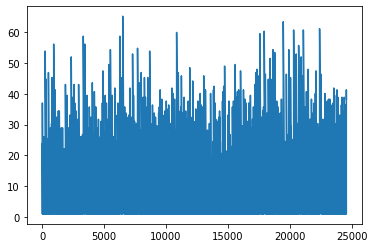

In [12]:
import matplotlib.pyplot as plt
aux_rewards = []
for i in range(len(rewards)):
    for j in range(len(rewards[i])):
        aux_rewards.append(rewards[i][j])
    
plt.plot(aux_rewards)
plt.show()

In [13]:
algo.save_weights("saved_models/PPO")

## test

In [ ]:
# Pick algorithm to test
if(args.type=="DDQN"):
    algo = DDQN(action_dim, state_dim, args)
elif(args.type=="A2C"):
    algo = A2C(action_dim, state_dim, args.consecutive_frames)
elif(args.type=="PPO"):
    algo = PPO(action_dim, state_dim, args.consecutive_frames)
elif(args.type=="A3C"):
    algo = A3C(action_dim, state_dim, args.consecutive_frames, is_atari=args.is_atari)
elif(args.type=="DDPG"):
    algo = DDPG(action_dim, state_dim, act_range, args.consecutive_frames)

In [ ]:
algo.load_weights("saved_models/PPO_LR_0.0001_actor.h5", "saved_models/PPO_LR_0.0001_critic.h5")

In [ ]:
# Reset episode
num_test_int = 10
global_info = []

for i in range(num_test_int):
    time, cumul_reward, done = 0, 0, False
    old_state = env.reset()
    
    while not done:
        env.render()
        # Actor picks an action (following the policy)
        a = algo.policy_action(old_state)
        # Retrieve new state, reward, and whether the state is terminal
        new_state, r, done, _ = env.step(a)
        # Update current state
        old_state = new_state
        cumul_reward += r
        time += 1
        
        if done: 
            global_info.append({
                cumul_reward
            })